/home/aiadmin/Desktop/code/vm2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/aiadmin/Desktop/code/vm2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

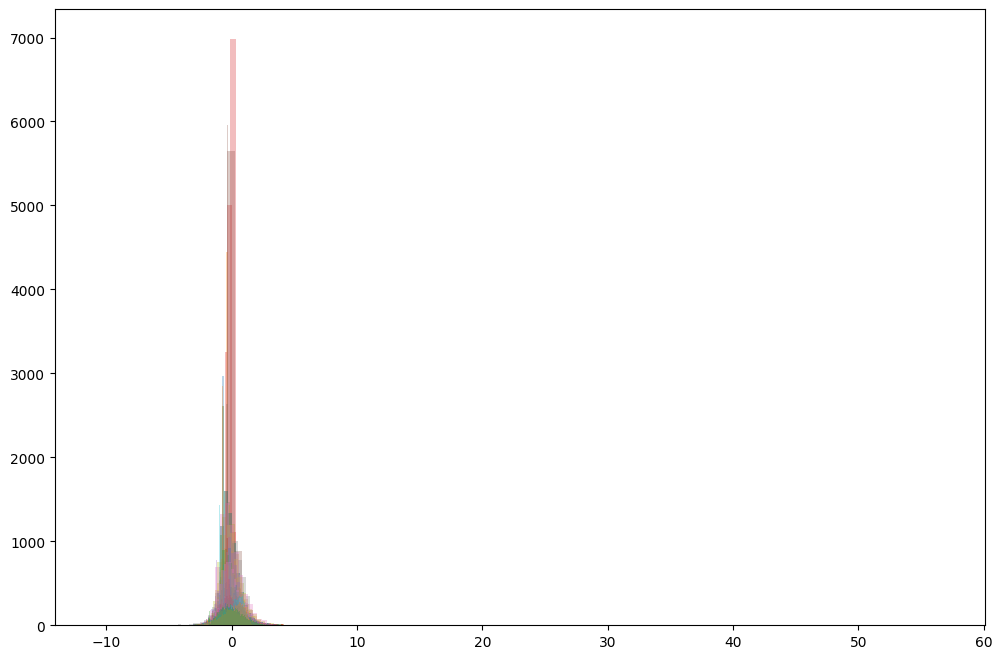

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file1 = pd.read_csv('ABB_30_embeddings.csv')
file2 = pd.read_csv('ABB_70_embeddings.csv')
file3 = pd.read_csv('AGG_30_embeddings.csv')
file4 = pd.read_csv('AGG_70_embeddings.csv')
combined_df = pd.concat([file1, file2, file3, file4])
numeric_columns = combined_df.select_dtypes(include='number').columns

zscore_df = combined_df.copy()
zscore_df[numeric_columns] = zscore_df[numeric_columns].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
plt.figure(figsize=(12, 8))

for col in numeric_columns:
    plt.hist(zscore_df[col], bins=100, alpha=0.3, label=col, edgecolor='none')

plt.title('Compounded Final Matrix Graph of Z-Score Distributions Across All Features')
plt.xlabel('Z-Score Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
